In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pylab import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Изучаем данные

In [76]:
data = pd.read_excel('Sarah gets a diamond data.xls', sheet_name=0, header=2)

In [77]:
data.head()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.0
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.0
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.0
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.0
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.0


In [78]:
data.describe() #max Carat Weight не норм

,ID,Carat Weight,Price
count,6000.000000,6000.000000,4500.000000
mean,3000.500000,3.917720,11673.305341
std,1732.195139,147.327106,10067.895595
min,1.000000,0.750000,-10001.000000
25%,1500.750000,1.000000,5126.000000
50%,3000.500000,1.130000,7868.500000
75%,4500.250000,1.590000,14942.750000
max,6000.000000,10002.000000,101561.000000


In [79]:
data.isna().sum()

ID                 0
Carat Weight       0
Cut                0
Color              1
Clarity            0
Polish             0
Symmetry           1
Report             0
Price           1500
dtype: int64

In [80]:
{column: len(data[column].unique()) for column in data.columns}

{'ID': 6000,
 'Carat Weight': 198,
 'Cut': 8,
 'Color': 8,
 'Clarity': 8,
 'Polish': 5,
 'Symmetry': 6,
 'Report': 2,
 'Price': 3792}

In [81]:
data.drop(['ID', 'Symmetry', 'Report', 'Polish'], axis='columns', inplace=True) #уберем ненужные и слабо влияющие данные

In [82]:
data_u = data.copy()
data_u.drop(['Carat Weight', 'Price'], axis='columns', inplace=True)                    #Уникальные элементы в столбцах
{print(data_u[column].unique()): data_u[column].unique() for column in data_u.columns}

['Ideal' 'Very Good' 'Fair' 'Good' 'Signature-Ideal' '-' 'Ideallll'
 'ssssssssss']
['H' 'E' 'G' 'D' 'F' 'I' nan '-']
['SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'IF' 'FL' ' ']


{None: array(['SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'IF', 'FL', ' '], dtype=object)}

In [83]:
data['Cut'].replace(['Ideallll', 'ssssssssss', ' ', '-'], data['Cut'].value_counts().index[0], inplace=True)
data['Color'].replace(['', '-', 'SI1'], data['Color'].value_counts().index[0], inplace=True)
data['Color'].replace(np.nan, data['Clarity'].value_counts().index[0], inplace=True)
data['Clarity'].replace(' ', data['Clarity'].value_counts().index[0], inplace=True)

for j in range(data.shape[0]):
    for i in data[j:j+1]['Carat Weight'].unique():
        if i > 10:
            data['Carat Weight'].replace(i, data['Carat Weight'].value_counts().index[0], inplace=True)
        else:
            n = 0
data.shape

(6000, 5)

In [84]:
cln = data.dropna()

In [85]:
cln.describe()

,Carat Weight,Price
count,4500.000000,4500.000000
mean,1.331131,11673.305341
std,0.474956,10067.895595
min,0.750000,-10001.000000
25%,1.000000,5126.000000
50%,1.130000,7868.500000
75%,1.580000,14942.750000
max,2.910000,101561.000000


In [86]:
cln.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Carat Weight,Price
Carat Weight,1.00,0.85
Price,0.85,1.00


## График Цены в зависимости от Карат; С градацией по Огранке

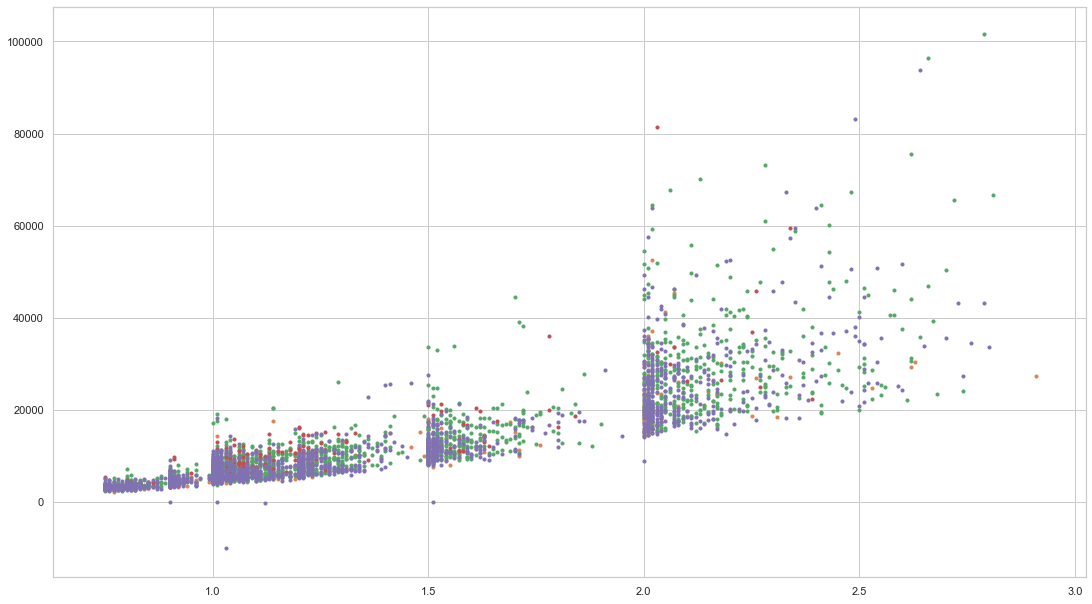

In [87]:
cln1 = cln.copy()
fig, ax = plt.subplots()
for c, cln1 in cln1.groupby('Cut'):
    ax.scatter(cln1['Carat Weight'], cln1['Price'], label=c, s=np.pi*3)
fig.set_size_inches(18.5, 10.5)

## График Цены в зависимости от Карат; С градацией по Цвету

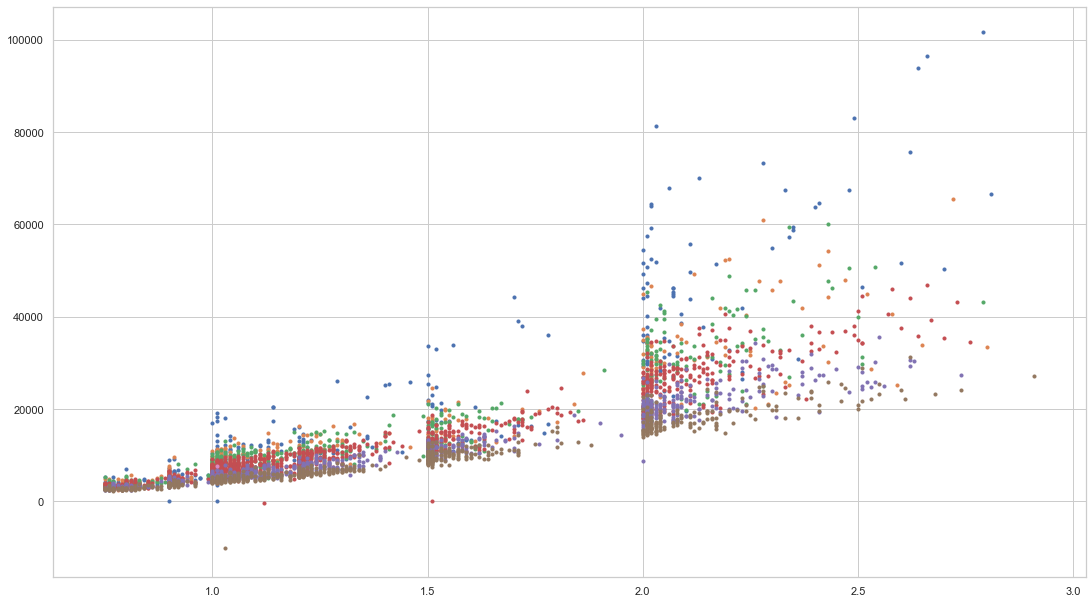

In [88]:
cln1 = cln.copy()
fig, ax = plt.subplots()
for c, cln1 in cln1.groupby('Color'):
    ax.scatter(cln1['Carat Weight'], cln1['Price'], label=c, s=np.pi*3)
fig.set_size_inches(18.5, 10.5)

## График Цены в зависимости от Карат; С градацией по Чистоте

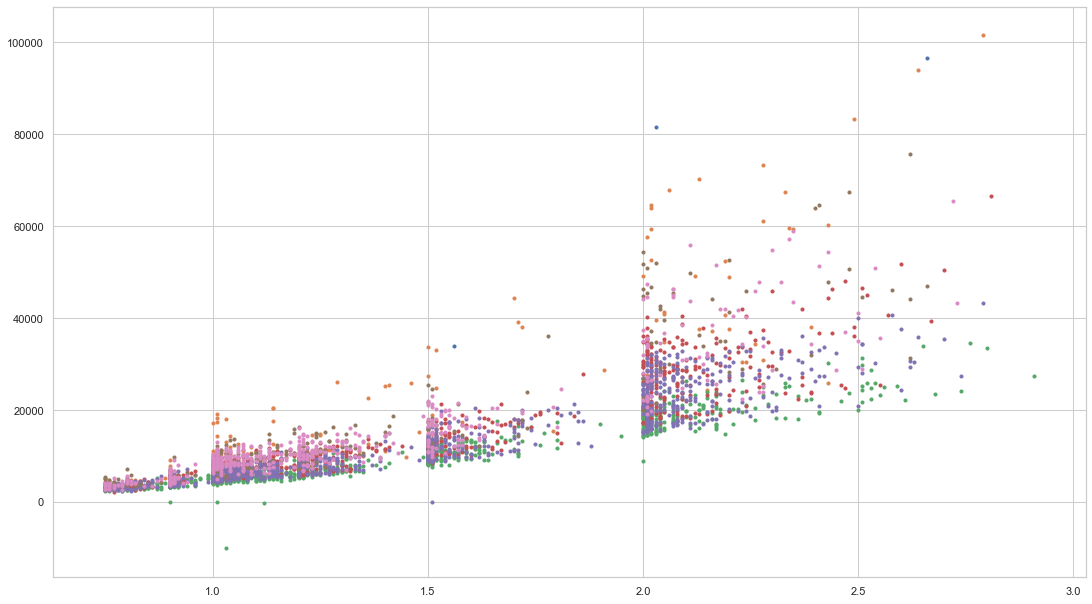

In [89]:
cln1 = cln.copy()
fig, ax = plt.subplots()
for c, cln1 in cln1.groupby('Clarity'):
    ax.scatter(cln1['Carat Weight'], cln1['Price'], label=c, s=np.pi*3)
fig.set_size_inches(18.5, 10.5)

# Функция для прогноза цены

In [90]:
znaem = data.dropna() # Изучаемые данные

In [91]:
#Функция принимает на вход строку из базы данных **Информацию о бриллианте**
#Из базы известных данных отбираются те данные, которые по качественным характеристикам схожи с входным бриллиантом
#**Если таких данных слишком мало, то срабатывает except**
#Далее строится полиномиальная регрессия степени 2 для прогноза

def prognoz(stroka):
    try:
        cln = znaem.copy()
        cuts = ['Ideal', 'Very Good', 'Fair', 'Good', 'Signature-Ideal']   # Списки уникальных элементов/характеристик
        colors = ['H', 'E', 'G', 'D', 'F', 'I']
        Clarities = ['SI1', 'VS1','VS2','VVS2','VVS1','IF','FL']
        cut = stroka['Cut'].unique()[0]
        color = stroka['Color'].unique()[0]         #Достаем данные о бриллианте
        clar = stroka['Clarity'].unique()[0]
        cln1 = cln.copy()
        cln1['Cut'].replace([a for a in cuts.copy() if a != cut], np.nan, inplace=True)
        cln1 = cln1.dropna()
        cln2 = cln1.copy()
        cln2['Color'].replace([a for a in colors.copy() if a != color], np.nan, inplace=True)
        cln2 = cln2.dropna()
        cln3 = cln2.copy()
        cln3['Clarity'].replace([a for a in Clarities.copy() if a != clar], np.nan, inplace=True)
        cln3 = cln3.dropna()
        cln3 = cln3.drop(['Cut','Color','Clarity'], axis=1)
    
    
        X=np.array(cln3[['Carat Weight']])
        y=np.array(cln3['Price'])
    
        model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept = False))
        model.fit(X,y)
        X_predict = np.array([[3]])
        p2 = np.poly1d(np.polyfit(X.ravel(),y, 2))
        itog = round(p2(stroka['Carat Weight'].unique()[0]), 2)
    except:
        X=np.array(cln[['Carat Weight']])
        y=np.array(cln['Price'])
    
        model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept = False))
        model.fit(X,y)
        X_predict = np.array([[3]])
        p2 = np.poly1d(np.polyfit(X.ravel(),y, 2))
        itog = round(p2(stroka['Carat Weight'].unique()[0]), 2)
        
    return itog

# Записываем файл с прогнозом  последних 1500 бриллиантов в списке

In [92]:
# Достаем и исправляем базу данных
data1 = pd.read_excel('Sarah gets a diamond data.xls', sheet_name=0, header=2)

data1['Cut'].replace(['Ideallll', 'ssssssssss', ' ', '-'], data1['Cut'].value_counts().index[0], inplace=True)
data1['Color'].replace(['', '-', 'SI1'], data1['Color'].value_counts().index[0], inplace=True)
data1['Color'].replace(np.nan, data1['Clarity'].value_counts().index[0], inplace=True)
data1['Clarity'].replace(' ', data1['Clarity'].value_counts().index[0], inplace=True)
data1['Symmetry'].replace(np.nan, data1['Symmetry'].value_counts().index[0], inplace=True)

for j in range(data1.shape[0]):
    for i in data1[j:j+1]['Carat Weight'].unique():
        if i > 10:
            data1['Carat Weight'].replace(i, data1['Carat Weight'].value_counts().index[0], inplace=True)
        else:
            n = 0

In [93]:
data1

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.0
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.0
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.0
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.0
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.0
...,...,...,...,...,...,...,...,...,...
5995,5996,1.03,Ideal,D,SI1,EX,EX,GIA,NaN
5996,5997,1.00,Very Good,D,SI1,VG,VG,GIA,NaN
5997,5998,1.02,Ideal,D,SI1,EX,EX,GIA,NaN
5998,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,NaN


In [94]:
# Записываем прогноз последних бриллиантов
for i in range(0, 1500):
    data1[4500+i:4501+i]['Price'].replace(np.nan, prognoz(data1[4500+i:4501+i]), inplace=True)

C:\Users\Alex Dubovsky\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alex Dubovsky\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alex Dubovsky\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alex Dubovsky\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alex Dubovsky\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid 

In [95]:
data1.isna().sum()

ID              0
Carat Weight    0
Cut             0
Color           0
Clarity         0
Polish          0
Symmetry        0
Report          0
Price           0
dtype: int64

In [96]:
data1

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.00
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.00
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.00
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.00
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.00
...,...,...,...,...,...,...,...,...,...
5995,5996,1.03,Ideal,D,SI1,EX,EX,GIA,5843.32
5996,5997,1.00,Very Good,D,SI1,VG,VG,GIA,5385.70
5997,5998,1.02,Ideal,D,SI1,EX,EX,GIA,5738.94
5998,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11395.12


In [97]:
# Сохраняем окончательный файл

file = 'Прогноз цен.xls'
data1.to_excel(file, index=False)